# Computer vision and deep learning - Laboratory 4

This laboratory will span over two sessions, and you will exercise more of your torch skills. Also, you will learn how to perform experiment tracking using the popular wandb framework.

We'll be implementing, training and testing a semantic segmentation model. The task of semantic segmentation implies the labeling/classification of __all__ the pixels in the input image.

You'll build and train a fully convolutional neural network inspired by U-Net.
Also, you will learn about how you can use various callbacks during the training of your model.


Today, we'll focus on the data loading and preprocessing part, and we'll study the building blocks of the semantic segmentation module.

In [1]:
# %pip install wget
# %pip install wandb -qU

import os
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [ ]:
!mkdir 'cvdl_lab_4'


ModuleNotFoundError: No module named 'google.colab'

In [ ]:

!cd cvdl_lab_4
!pwd

/content


## Data loading

We'll be working with the [Labeled Faces in the Wild dataset](https://vis-www.cs.umass.edu/lfw/) which contains facial images, and each pixel in the image is annotated with the following three classes: background, skin, and hair. The dataset with the segmentation masks can be found [here](https://vis-www.cs.umass.edu/lfw/part_labels/).

Alternatively, if you have more computing power, you can work with [CelebA-MaskHQ dataset](https://github.com/switchablenorms/CelebAMask-HQ).

To sum up, the pages for the dataset are:

| Dataset  | Number of samples  |  Link |
|---|---|---|
| LFWParts | 2927    |  https://vis-www.cs.umass.edu/lfw/part_labels/ |
| CelebAMaskHQ | 30000  |  https://github.com/switchablenorms/CelebAMask-HQ |

Read the documentation (webpages) of these datasets and start processing the data.
Remeber that the dataset needs to be split into train/test sets!

Start by downloading the input images and the segmentation masks from the official website of the dataset that you chose, and then write the code that allows you to use the images.


As you remember from the previous lab, in _torch_ you have two data primitives that allow you to interact with the data: torch.utils.data.Dataset and torch.utils.data.DataLoader.

You need to write a subclass of the torch.utils.data.Dataset class.

torch.utils.data.Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

[More details in the doc.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)




## Writing a custom Dataset

Start by writing a custom dataset for your problem.

Each custom dataset must implement the following methods:
- \_\_init\_\_ : the constructor is run when instantiating the Dataset object. Here you should do the initializations (input dirs, dataset splits) and the transforms (covered in more detail in the next section).
- \_\_len\_\_ : this should return the number of samples in the dataset;
- \_\_getitem\_\_ : this should load and return a sample from the dataset at the given index _idx_ (passed as a parameter). Based on the index, it identifies the image and its corresponding segmentation map location on disk, calls the transform functions on them (if applicable), and returns the tensor image and mask in a tuple.


Below you have the main structure of the LFWDataset dataset class that allows you to download programatically the images (you should consider moving the download helper functions in another module).

In [3]:

import os
from PIL import Image
import torch
import hashlib
import tarfile
import requests
from tqdm import tqdm


class LFWDataset(torch.utils.data.Dataset):
    _DATA = (
        # images
        ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", None),
        # segmentation masks as ppm
        ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz",
         "3e7e26e801c3081d651c8c2ef3c45cfc"),
    )
    _SPLIT_NAMES = {
        "train": "https://vis-www.cs.umass.edu/lfw/part_labels/parts_train.txt",
        "validation": "https://vis-www.cs.umass.edu/lfw/part_labels/parts_validation.txt",
        "test": "https://vis-www.cs.umass.edu/lfw/part_labels/parts_test.txt"
    }

    def __init__(self, base_folder, transforms, download=True, split_name: str = 'train'):
        super().__init__()
        self.base_folder = base_folder
        # TODO your code here: if necessary download and extract the data
        # TODO based on the split_name get the paths of the samples and their corresponding ground truth
        anno_path = os.path.join(base_folder, 'parts_lfw_funneled_gt_images')
        img_path = os.path.join(base_folder, 'lfw_funneled')
        if download:
            self.download_resources(base_folder)
        self.transforms = transforms
        self.X = []
        self.Y = [os.path.join(anno_path, img) for img in os.listdir(anno_path) if img[0]!='.' and img.endswith('ppm')]

        for a in self.Y:
            ab = os.path.basename(a)
            self.X.append(os.path.join(img_path, ab[:-9]) + "/" + ab.replace('.ppm', '.jpg'))
            
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # TODO your code here: return the idx^th sample in the dataset: image, segmentation mask
        # TODO your code here: if necessary apply the transforms

        image = Image.open(self.X[idx])
        mask = Image.open(self.Y[idx])
        if(self.transforms is not None):
            image, mask = self.transforms(image, mask)
        return image, mask

        

    def download_resources(self, base_folder):
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        self._download_and_extract_archive(url=LFWDataset._DATA[1][0], base_folder=base_folder,
                                           md5=LFWDataset._DATA[1][1])
        self._download_and_extract_archive(url=LFWDataset._DATA[0][0], base_folder=base_folder, md5=None)
        self._download_url(url=LFWDataset._SPLIT_NAMES['train'], base_folder=base_folder, md5=None)
        self._download_url(url=LFWDataset._SPLIT_NAMES['validation'], base_folder=base_folder, md5=None)
        self._download_url(url=LFWDataset._SPLIT_NAMES['test'], base_folder=base_folder, md5=None)

    def _download_and_extract_archive(self, url, base_folder, md5) -> None:
        """
          Downloads an archive file from a given URL, saves it to the specified base folder,
          and then extracts its contents to the base folder.

          Args:
          - url (str): The URL from which the archive file needs to be downloaded.
          - base_folder (str): The path where the downloaded archive file will be saved and extracted.
          - md5 (str): The MD5 checksum of the expected archive file for validation.
          """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)

        self._download_url(url, base_folder, md5)
        archive = os.path.join(base_folder, filename)
        print(f"Extracting {archive} to {base_folder}")
        self._extract_tar_archive(archive, base_folder, True)

    def _retreive(self, url, save_location, chunk_size: int = 1024 * 32) -> None:
        """
            Downloads a file from a given URL and saves it to the specified location.

            Args:
            - url (str): The URL from which the file needs to be downloaded.
            - save_location (str): The path where the downloaded file will be saved.
            - chunk_size (int, optional): The size of each chunk of data to be downloaded. Defaults to 32 KB.
            """
        try:
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))

            with open(save_location, 'wb') as file, tqdm(
                    desc=os.path.basename(save_location),
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    bar.update(len(data))

            print(f"Download successful. File saved to: {save_location}")

        except Exception as e:
            print(f"An error occurred: {str(e)}")

    def _download_url(self, url: str, base_folder: str, md5: str = None) -> None:
        """Downloads the file from the url to the specified folder

        Args:
            url (str): URL to download file from
            base_folder (str): Directory to place downloaded file in
            md5 (str, optional): MD5 checksum of the download. If None, do not check
        """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)
        file_path = os.path.join(base_folder, filename)

        os.makedirs(base_folder, exist_ok=True)

        # check if the file already exists
        if self._check_file(file_path, md5):
            print(f"File {file_path} already exists. Using that version")
            return

        print(f"Downloading {url} to file_path")
        self._retreive(url, file_path)

        # check integrity of downloaded file
        if not self._check_file(file_path, md5):
            raise RuntimeError("File not found or corrupted.")

    def _extract_tar_archive(self, from_path: str, to_path: str = None, remove_finished: bool = False) -> str:
        """Extract a tar archive.

        Args:
            from_path (str): Path to the file to be extracted.
            to_path (str): Path to the directory the file will be extracted to. If omitted, the directory of the file is
                used.
            remove_finished (bool): If True , remove the file after the extraction.
        Returns:
            (str): Path to the directory the file was extracted to.
        """
        if to_path is None:
            to_path = os.path.dirname(from_path)

        with tarfile.open(from_path, "r") as tar:
            tar.extractall(to_path)

        if remove_finished:
            os.remove(from_path)

        return to_path

    def _compute_md5(self, filepath: str, chunk_size: int = 1024 * 1024) -> str:
        with open(filepath, "rb") as f:
            md5 = hashlib.md5()
            while chunk := f.read(chunk_size):
                md5.update(chunk)
        return md5.hexdigest()

    def _check_file(self, filepath: str, md5: str) -> bool:
        if not os.path.isfile(filepath):
            return False
        if md5 is None:
            return True
        return self._compute_md5(filepath) == md5


if __name__ == '__main__':
    LFWDataset(download=False, base_folder='lfw_dataset', transforms=None)


Inspect the pixels values that you have in a segmentation mask.

In [4]:
# TODO your code here
flw_data = LFWDataset(download=False, base_folder='lfw_dataset', transforms=None)

def inspect_first_segementation_mask_pixels(idx):
    image, mask = flw_data.__getitem__(idx)
    mask_array = np.array(mask)
    print(f"Segmentation Mask Pixel Values (image {idx}):")
    print(mask_array)
    
inspect_first_segementation_mask_pixels(0)


Segmentation Mask Pixel Values (image 0):
[[[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 ...

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]

 [[  0   0 255]
  [  0   0 255]
  [  0   0 255]
  ...
  [  0   0 255]
  [  0   0 255]
  [  0   0 255]]]


## Dataloaders

By now you have a class that can easily retrieve one sample (image and segmentation map) at a time from your dataset. However, when training a model, you usually pass data in batches, you need to shuffle the data at each epoch and Python’s multiprocessing to speed up data retrieval.
Fortunately, all these are provided by the DataLoader.


[Tips](https://wandb.ai/wandb/trace/reports/A-Public-Dissection-of-a-PyTorch-Training-Step--Vmlldzo5MDE3NjU) on speeding up the dataloaders.

In [7]:
#in this example we are using OxfordIIITPet which also contains segmentation masks (you should replace this with your Dataset class)
test_data = torchvision.datasets.OxfordIIITPet(root='/lab4/oxford', split="test", target_types="segmentation", download=True,
                                               transforms= v2.Compose([
                                                            v2.Resize(256),
                                                            v2.CenterCrop(224),
                                                            v2.ToTensor()]))

datalfw = LFWDataset(download=False, base_folder='lfw_dataset', transforms=v2.Compose([v2.Resize(256), v2.CenterCrop(224), v2.ToTensor()]))

d:\University-Projects\Semester5\Computer Vision and Deep Learning\venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


100%|██████████| 791918971/791918971 [00:58<00:00, 13440088.73it/s]


Extracting \lab4\oxford\oxford-iiit-pet\images.tar.gz to \lab4\oxford\oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 13301550.80it/s]


Extracting \lab4\oxford\oxford-iiit-pet\annotations.tar.gz to \lab4\oxford\oxford-iiit-pet


In [5]:
datalfw = LFWDataset(download=False, base_folder='lfw_dataset', transforms=v2.Compose([v2.Resize(256), v2.CenterCrop(224), v2.ToTensor()]))

d:\University-Projects\Semester5\Computer Vision and Deep Learning\venv\lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


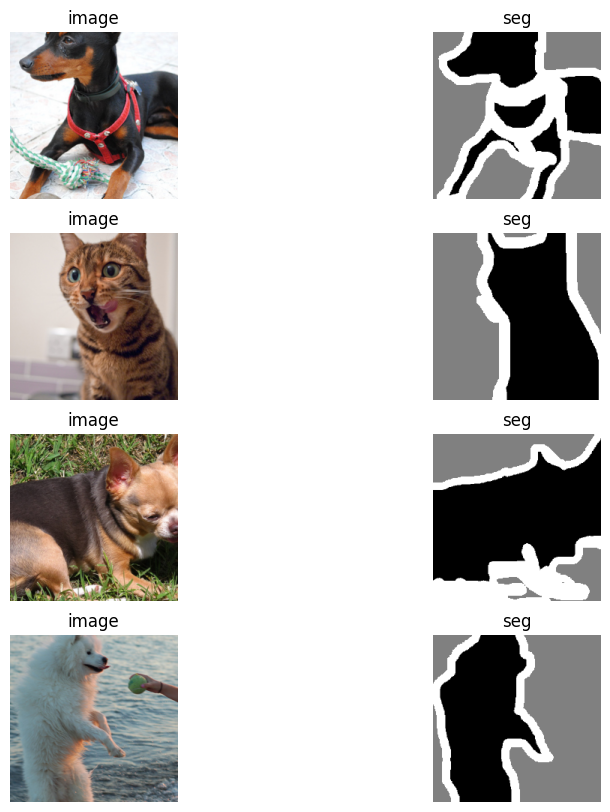

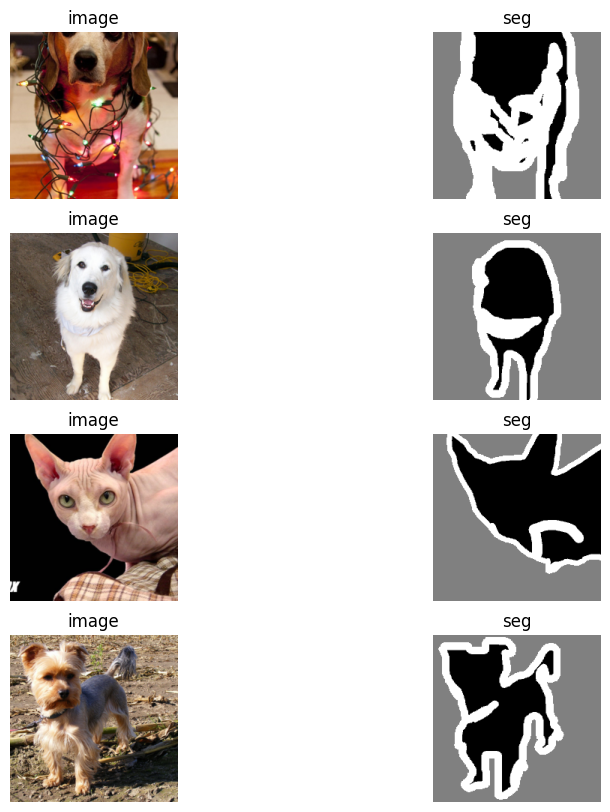

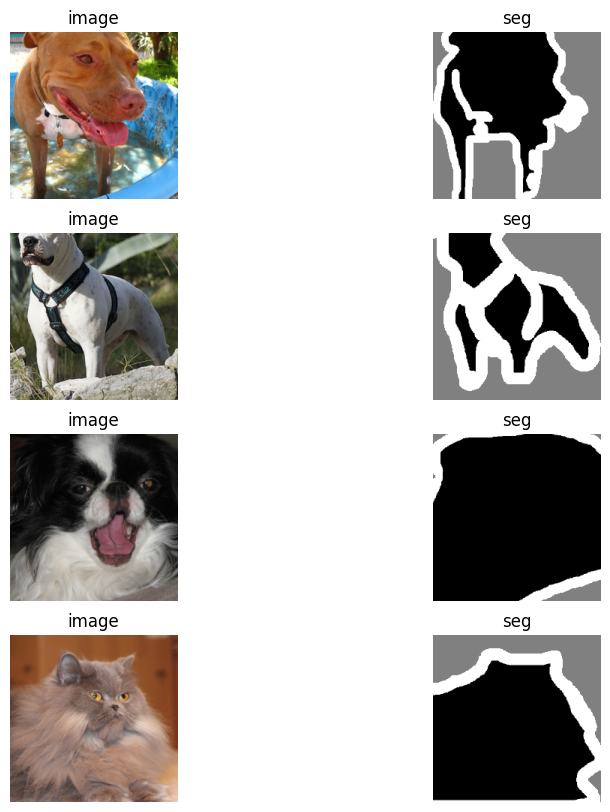

In [8]:
# let's create a DataLoader to easily iterate over this dataset

bs = 4
dataloader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    imgs = sample_batched[0]
    segs = sample_batched[1]

    rows, cols = bs, 2
    figure = plt.figure(figsize=(10, 10))

    for i in range(0, bs):
        figure.add_subplot(rows, cols, 2*i+1)
        plt.title('image')
        plt.axis("off")
        plt.imshow(imgs[i].numpy().transpose(1, 2, 0))

        figure.add_subplot(rows, cols, 2*i+2)
        plt.title('seg')
        plt.axis("off")
        plt.imshow(segs[i].numpy().transpose(1, 2, 0), cmap="gray")
    plt.show()
    # display the first 3 batches
    if i_batch == 2:
        break


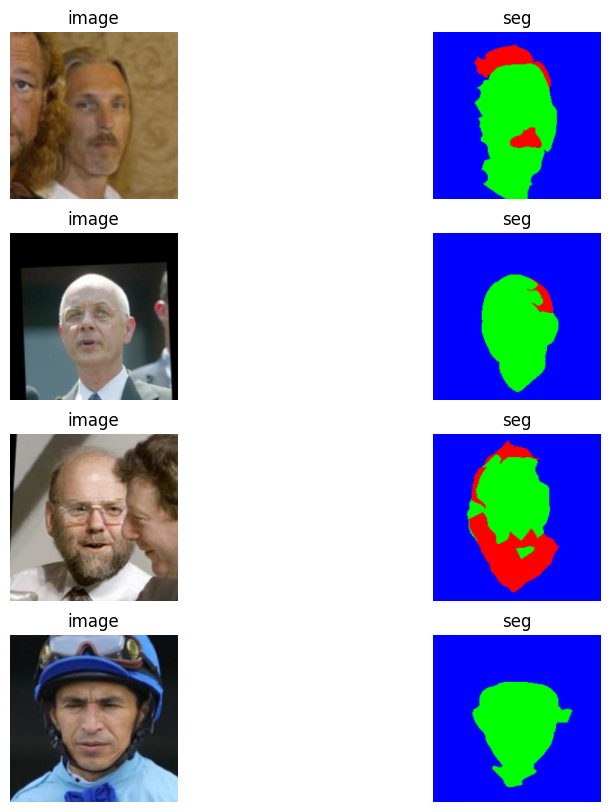

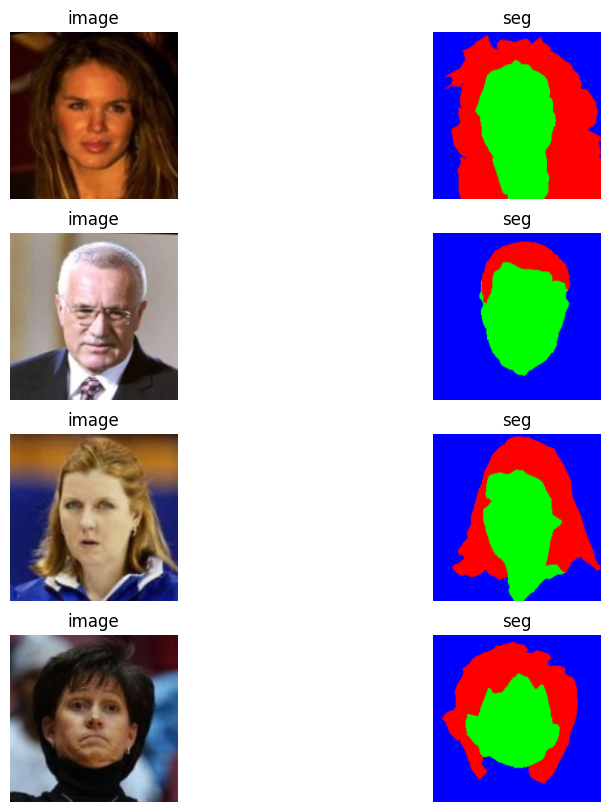

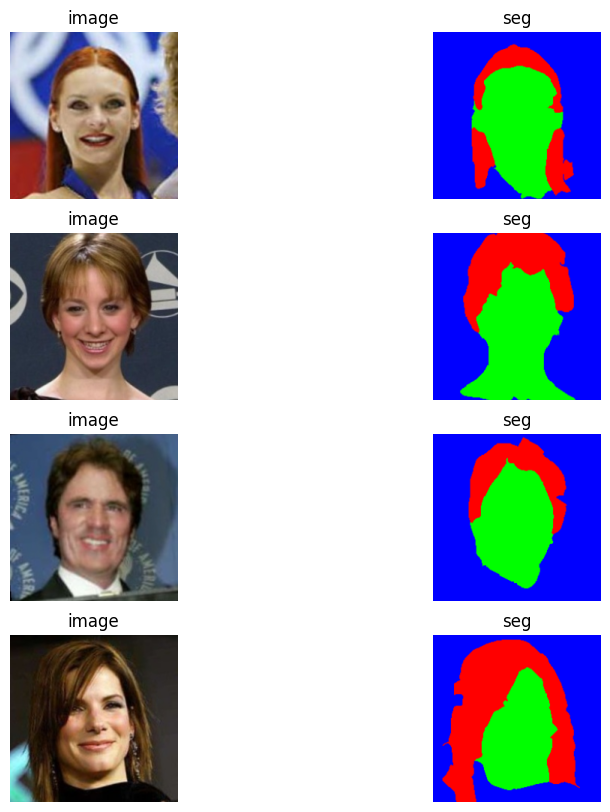

In [9]:
# let's create a DataLoader to easily iterate over this dataset

bs = 4
dataloader = torch.utils.data.DataLoader(datalfw, batch_size=bs, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    imgs = sample_batched[0]
    segs = sample_batched[1]

    rows, cols = bs, 2
    figure = plt.figure(figsize=(10, 10))

    for i in range(0, bs):
        figure.add_subplot(rows, cols, 2*i+1)
        plt.title('image')
        plt.axis("off")
        plt.imshow(imgs[i].numpy().transpose(1, 2, 0))

        figure.add_subplot(rows, cols, 2*i+2)
        plt.title('seg')
        plt.axis("off")
        plt.imshow(segs[i].numpy().transpose(1, 2, 0), cmap="gray")
    plt.show()
    # display the first 3 batches
    if i_batch == 2:
        break


## Building the model

The model that will be used in this laboratory is inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.
U-Net is a fully convolutional neural network comprising two symmetric paths: a contracting path (to capture context) and an expanding path  (which enables precise localization).
The network also uses skip connections between the corresponding layers in the downsampling path to the layer in the upsampling path, and thus directly fast-forwards high-resolution feature maps from the encoder to the decoder network.

The output of the model is an volume with depth C, where C is the number of pixel classes. For example, if you want to classify the pixels into person and background, the output will be a volume of depth 2.
If you want to classify the pixels into face, hair and background the output will be a volume of depth 3.

**Read the U-Net paper and try to understand the architecture.**

An overview of the U-Net architecture is depicted in the figure below:
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png"/>




## The downsampling path


For the downsampling path we'll use a convolutional neural network from the pretrained torchvision models.
We'll cover this in detail in the next laboratory session.


## The upsamping path


In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


In [11]:
import torch
def upsample_block(x, filters, size, stride = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """

  # TODO your code here
  # transposed convolution
  upsample= torch.nn.ConvTranspose2d(in_channels=x.shape[1], out_channels=filters, kernel_size=size, stride=stride, padding=1)
  x = upsample(x)
  # BN
  bn  = torch.nn.BatchNorm2d(num_features=filters)
  # relu activation
  relu = torch.nn.ReLU()
  x = relu(x)
  return x

Now let's test this upsampling block

In [12]:
in_layer = torch.rand((32, 32, 128, 128))

filter_sz = 4
num_filters = 16

for stride in [2, 4, 8]:
  x = upsample_block(in_layer, num_filters, filter_sz, stride)
  print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_sz, '; stride ', stride, ' -> out shape ', x.shape)

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 256, 256])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 510, 510])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1018, 1018])


# Hello wandb

Weights and Biases [wandb](https://wandb.ai/) is a machine learning experiment tracking and visualization tool which allows you to easily track, visualize, and collaborate on machine learning experiments. You will use wandb a to log and track various parameters, such as your hyperparameters, model performance metrics, data visualizations and system metrics.

For now, just check out [this tutorial](https://docs.wandb.ai/guides/integrations/pytorch) on how you can easily integrate wandb with pytorch. Just look at the functions from wandb and how they are used, such that next time you hvae an ideea on how to structure your project.

You will also use [wandb sweeps](https://docs.wandb.ai/guides/sweeps) to automate hyperparameter tuning. This module explores different combinations of hyperparameters to help users find the best configuration for their models.
Sweep configurations can be defined using YAML files or programmatically in dictionaries, and wandb takes care of running multiple experiments with different parameter combinations, keeping track of results, and displaying them in a comprehensive dashboard for analysis.

